# Do attractive Redditors get more upvotes?


**Group 17**: **Jack Silk** (jsilk13), **David Haas** (dhaas6), **Spencer Mullinix** (mullisd1)

<b>Is there a correlation between the attractiveness of the redditor and the number of upvotes they get?</b>  We believe that the higher the physical attractiveness of the redditor is, the more upvotes they will receive.  Whether it is conscious or subconscious, we think that to some degree, users decide whether to upvote a post or not based on the attractivness of the poster.

<b>How will we determine the physical attractiveness of a Reddit user?</b>  We are going to use a facial recognition algorithm to apply a rating of physical attractiveness to the user.  Dlib's facial recognition tool creates a vector of 128 values based on the features of a person's face.  We will use this vector to create our rating scale.

In [8]:
# Sciences
import face_recognition
import numpy as np

# Scraping
import praw, psaw
import requests
from io import BytesIO
from datetime import datetime

# Other
import pickle
from tqdm import tqdm
from PIL import Image
import traceback
import os


In [23]:
def encode_image(img_path):
    """ Returns encoding
    """
    img = face_recognition.load_image_file(img_path)

    # Search for faces and encode
    face_locs = face_recognition.face_locations(img)
    if len(face_locs) > 0:
        return face_recognition.face_encodings(img, known_face_locations=face_locs)
    else:
        return [np.zeros((128))]

In [24]:
# Connect to Reddit and Pushshift
reddit_client = praw.Reddit(client_id='6ZOjAwnqUehb5Q', 
                            client_secret='gc4rkA50yNq9pBn1diU11Xj1nKY', 
                            user_agent='ffinder_test')
api = psaw.PushshiftAPI(reddit_client)
deleted_reddit, deleted_imgur = pickle.load(open('./content/deleted_binaries.pkl', 'rb'))

Data Gathered:


*   Facial encodings of pictures containing faces
*   URLs to Reddit post and direct image
*   The score for that post (upvotes - downvotes)

generate_encodings() makes Pushshift API calls, collecting results for the inputted subreddit over a given time period. Each result is passed into process_image() which encodes any present faces and extracts the metadata (URLs and score).

After the face_limit is met in generate_encodings, the function returns an two arrays, one for the encodings and one for the metadata.

In [25]:
def is_img(path):
    return path[-4:] in {".png", '.jpg'}


def process_image(api_result):
    """ Downloads image from the Pushshift api entry and encodes it if there are faces present
        Arguments:
            api_result (psaw api result): A single entry in the psaw search query result
        Returns:
            False if unsuccessful
            tuple of encoding and metadata if successfull
    """
    if not is_img(api_result.url):  return False

    # Fetch and load image
    try:
        img_bytes = requests.get(api_result.url).content
        if img_bytes == deleted_imgur or img_bytes == deleted_reddit:  return False
        img = face_recognition.load_image_file(BytesIO(img_bytes))
    except:
        return False

    # Search for faces and encode
    face_locs = face_recognition.face_locations(img)
    if len(face_locs) > 0:
        encodings = face_recognition.face_encodings(img, known_face_locations=face_locs)
        return encodings, (api_result.shortlink, api_result.url, api_result.score)
    else:
        return False


def generate_encodings(subreddit, face_limit=10e7):
    """ Generates a set of facial encodings from each valid image on a subreddit
        Given a subreddit, this function collects its images, starting with the most recent in multi-day chunks.
        After downloading an image, it is analyzed for faces, and if faces are present it generates an encoding
        and stores metadata about the image to be pickled and saved.
        
        Args:
            subreddit (str): The subreddit name to process images from
            image_limit (int): The maximum number of images to process.
        Returns:
            tuple: (A Nx128 matrix of encodings, a list of metadata corresponding by index to each row in the matrix)
    """

    encodings = np.zeros((0,128))
    metadata = []
    
    CHUNK_SIZE = 1 * 86400  # 1 day chunks
    chunk_end = datetime.now().timestamp()
    chunk_start = chunk_end - CHUNK_SIZE
    stop = False

    while not stop:
        prev_length = encodings.shape[0]
        face_data = []
        # Process the chunk of api data
        try:
            chunk_data = api.search_submissions(before=int(chunk_end), after=int(chunk_start), subreddit=subreddit)

            # Process the API results for faces
            face_data = list(map(process_image, chunk_data))

            # Separate and store face_data into encodings and metadata
            for entry in face_data:
                if type(entry) is not tuple:  continue
                enc, meta = entry
                encodings = np.vstack((encodings,enc))

                num_faces = len(enc)
                for i in range(num_faces):
                    metadata.append(meta)

            # Print results
            length = encodings.shape[0]
            num_added = length - prev_length
            face_per_img = 0 if len(face_data) == 0 else num_added/len(face_data)
            
            stop = length >= face_limit or length == prev_length
            print("%i new faces encoded (avg %.2f faces per image)! Total = %i" % (num_added, face_per_img, length))
        
        except Exception as e:
            print("ERROR: ")
            traceback.print_exc()

        chunk_end = chunk_start-1
        chunk_start = chunk_end - CHUNK_SIZE
        
    return encodings, metadata

In [ ]:
encodings, metadata = generate_encodings('selfies', 300)

With the ability to now collect large amounts of faces from Reddit and encode them, we can focus on the analysis of each encoding, and converting them to a beauty rating (1-5). 
We split this step between group members so that we could develop different approaches and avoid a bottleneck on this step.

First is our linear regression model.

Before we do any predicting, we must train the model off of the [SCUT-FBP5500](https://github.com/HCIILAB/SCUT-FBP5500-Database-Release) Dataset encodings

In [ ]:
# Build encodings (samples) as inputs to the regression model
import glob
from sklearn.linear_model import LinearRegression


datapath = './SCUT-FBP5500_v2/Images/*'
img_paths = glob.glob(datapath)
all_encodings = np.zeros((len(img_paths),128))

# Encode
for i, img_path in enumerate(img_paths):
    encodings = encode_image(img_path)
    for enc in encodings:
        all_encodings[i,:] = enc
        
# Save
np.save("SCUT-encodings.npy", all_encodings)

# Build labels (targets)
with open('SCUT-FBP5500_v2/train_test_files/All_labels.txt') as f:
    # keys: filenames  //  values: ratings
    file_labels = {line.split(' ')[0]:float(line.split(' ')[1].strip()) for line in f.readlines()}
    
    labels = np.zeros((len(img_paths)))
    for i,path in enumerate(img_paths):
        _, filename = os.path.split(path) 
        labels[i] = file_labels[filename]
        
    np.save("SCUT-labels.npy", labels)

In [12]:
all_encodings = np.load('SCUT-encodings.npy')
labels = np.load('SCUT-labels.npy')

In [13]:
# Train and score the model
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(all_encodings, labels)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
scores = cross_val_score(model, all_encodings, labels, scoring=make_scorer(mean_absolute_error))
print("Avg Mean Absolute Error: {0}, Std: {1}".format(scores.mean(), scores.std()))

[[-0.11003712  0.04569392  0.07832608 ... -0.03538962  0.04172648
  -0.00650166]
 [-0.02509105  0.04950476  0.01658421 ... -0.08789321  0.16508803
  -0.02094195]
 [-0.10630707  0.13151646  0.10914098 ... -0.06461035  0.06733254
  -0.01326104]
 ...
 [-0.08162953  0.05059871  0.03242504 ... -0.0759866   0.10453327
   0.03841674]
 [-0.09661861  0.05757315  0.07216612 ... -0.05055808 -0.03908116
   0.00097661]
 [-0.10787126  0.06926876  0.1401426  ... -0.00086246 -0.02051616
   0.05431798]]
[2.066667 3.433333 2.066667 ... 3.983333 1.9      3.833333]
Avg Mean Absolute Error: 0.30598227227473007, Std: 0.0049610452935545755


In [14]:
# Run the model on /r/roastme encodings
encodings, meta = pickle.load(open('roastme_1140-122419.pkl', 'rb'))
print("Num faces:", len(encodings))
ratings = model.predict(encodings)
print("Mean rating (1-5): {:0.2f}, std: {:1.1f}".format(ratings.mean(), ratings.std()))

FileNotFoundError: [Errno 2] No such file or directory: 'roastme_1140-122419.pkl'

(array([1.1100e+02, 9.9100e+02, 4.1620e+03, 1.3480e+04, 3.2134e+04,
        4.4454e+04, 3.0181e+04, 8.8980e+03, 1.0260e+03, 3.9000e+01]),
 array([0.92201495, 1.32300042, 1.72398589, 2.12497136, 2.52595683,
        2.9269423 , 3.32792777, 3.72891324, 4.12989871, 4.53088418,
        4.93186965]),
 <a list of 10 Patch objects>)

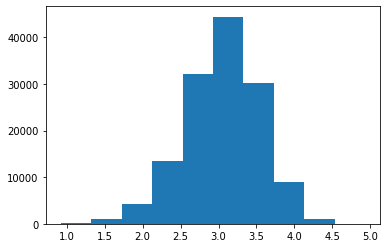

In [49]:
import matplotlib.pyplot as plt
plt.hist(ratings)

For such a large dataset, one would expect that if beauty, like other human phenotypes, is normally distributed, that the average output would be the median of possible scores (1 through 5). As one can see above, after analyzing 130,000+ faces, our model returns an average rating of 3/5: the median of possible scores.

Additionally, upon plotting the calculated ratings one can see that they are organized normally.

In [ ]:
from sklearn.neural_network import MLPRegressor
network = MLPRegressor(validation_fraction = 0, solver='adam', max_iter= 1000).fit(all_encodings, labels)
scores = cross_val_score(network, all_encodings, labels, scoring=make_scorer(mean_absolute_error))
print("Avg Mean Absolute Error: {0}, Std: {1}".format(scores.mean(), scores.std()))

In [11]:
# Run the model on /r/roastme encodings
print("Num faces:", len(encodings))
ratings = network.predict(encodings)
print("Mean rating (1-5): {:0.2f}, std: {:1.1f}".format(ratings.mean(), ratings.std()))
plt.hist(ratings)

FileNotFoundError: [Errno 2] No such file or directory: 'roastme_1140-122419.pkl'